# Coupled Decomposition

The idea behind coupled decomposition rebolves around the fact that as the total size of an image increases, the signal noise ratio in the identified correspondences decreases.  This relationship make matching exceptionally channeling (impossible really) for very large images without additional constraints.  One technique it to reduce the total size of the search spaces, thereby increasing the signal to noise ratio.

Coupled decomposition does this by recursively dividing two images into related sub-images.

In [1]:
import os
import math
import sys
sys.path.insert(0, os.path.abspath('..'))

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.matcher.feature import FlannMatcher

import time

import scipy as sp
from scipy.stats import pearsonr

%pylab inline
figsize(8,8)

Populating the interactive namespace from numpy and matplotlib


## Setup

This is the standard setup for the AutoCNet, where a manually created adjacency structure is defined.  Since this is just a tutorial example, we are pre-computing matches and applying outlier detection.  In practice, a decompose_and_match method is called to perform this operation together. (Thereby removing the need to match twice.)

In [6]:

a = get_path('AS15-M-0295_SML.png')
b = '/data/autocnet/autocnet/examples/Apollo15/AS15-M-0296_SML_rot10.png'

adjacency = {a:[b],
            b:[a]}

cg = CandidateGraph.from_adjacency(adjacency)
cg.extract_features(method='sift')
cg.match()
cg.ratio_checks()
cg.symmetry_checks()

## Decomposition
The second line of the cell below is the call to perform decomposition.  This algorithm finds the best match near the center of two images, computes the rotation angle of the second image to the first image, and then classifies the pixels in each resultant quadrant.  In other words - split each image into quadrants and rotate the second image until it is most like the first.  Once this is done, split each quadrant into 4 sections, compute the ideal rotation, and repeat. 

The results below demonstrate how each ~1000x1000 images is split in 16 sub-images.  The color of each sub-image indicates which class (group identifier) it belongs to.  At this point, the matching problem has gone from a search space of ~1000x1000 to a search space of ~200x200; this is a much easier task.

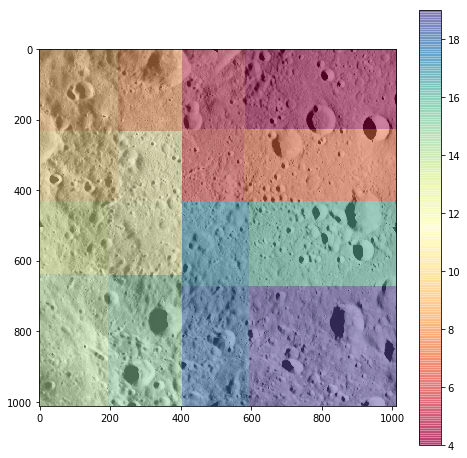

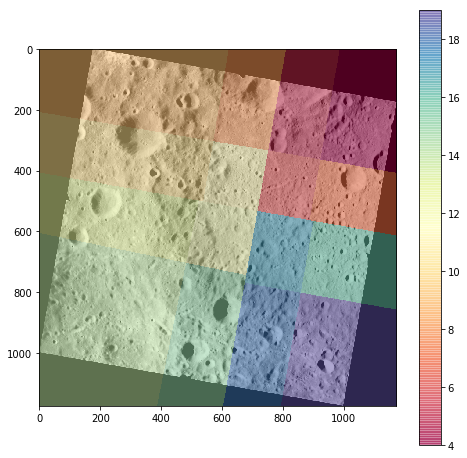

In [7]:
e = cg.edge[0][1]
e.decompose(maxiteration=2, ndv=0)
# Grab the matches data frame and identify the source and destination images and keypoints
matches, masks = cg.edge[0][1].clean(['ratio', 'symmetry'])
sidx = matches['source_idx']
snode = matches.iloc[0]['source_image']
didx = matches['destination_idx']
dnode = matches.iloc[0]['destination_image']

# Grab the original image arrays
sdata = cg.node[snode].geodata.read_array()
ddata = cg.node[dnode].geodata.read_array()

#Visualize for a sanity check
imshow(sdata, cmap='gray')
imshow(e.smembership, alpha=0.5, cmap='Spectral')
colorbar()
show()

imshow(ddata, cmap='gray')
imshow(e.dmembership, alpha=0.5, cmap='Spectral')
colorbar()
show()